# Building a Graph-Convolutional Neural Network

## Introduction

Structured objects are at the heart of drug discovery and biomedical science. Be it when optimising the shape of small molecules to bind in narrow protein pockets or analysing the topology of protein-protein interaction networks to find novel and effective targets, learning from large datasets of structured objects was and is a key challenge  when trying to address these biomedical problems with computational solutions.

As such, researchers have come up with a plethora of ways to convert the structural information of these objects of interest into a machine readable format. These started with domain experts hand-crafting rigid features (such as pharmacophore fingerprints) and have progressed to sophisticated usupervised machine learning methods that learn task-specific embeddings (such as variational autoencoders).

Over the past years, graph machine learning has crystallised out as the pre-eminent state-of-the-art approach (https://arxiv.org/pdf/2012.05716.pdf). By blurring the distinction between feature engineering and task learning, graph-convolutional neural networks are able to operate directly on nodes and edges, making maximal use of known structural properties.

As such, I decided to try to implement a graph-convolutional neural network from scratch (using only numpy). I will place particular focus on the backpropagation-driven gradient descent used to train these models.

The neural networks will be trained on a ChEMBL-derived lipophilicity dataset that consists of the SMILES-representation and measured aqueous solubility for 4200 molecules.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from abc import ABCMeta, abstractmethod
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('lipophilicity.csv')
features_smiles = data['smiles'].to_list()
labels = data['exp'].to_numpy()

# generate the first 10 descriptors specified by rdkit
def calcDescriptors(smiles):
    descriptors = {d[0]: d[1] for d in Descriptors.descList[:10]}
    desc = np.zeros((len(smiles), len(descriptors)))
    for i in range(len(smiles)):
        mol = MolFromSmiles(smiles[i])
        try:
            features = [descriptors[d](mol) for d in descriptors]
        except:
            raise Exception('molecule {}'.format(i) + ' is not canonicalised')
        desc[i, :] = features

    return desc

features_descriptors = calcDescriptors(features_smiles)

scaler = StandardScaler()
features_descriptors = scaler.fit_transform(features_descriptors)

# Starting with a Feed-Forward Neural Network

Before delving into sophisticated and convoluted GNNs, it might be useful to understand and implement key concepts and algorithms on a much simpler feed-forward neural network.

![A fully connected feed-forward neural net](ffnn.png)

A fully-connected feed-forward neural network consists of a series of linear transformations that are interspersed by non-linear activation functions, delimiting its layers. The weights of these linear transformations are iteratively trained with gradient descent to minimise an arbitrary loss function.

## Gradient Descent and Backpropagation

A fully connected neural network layer is defined as

$$\mathbf{Y}=\sigma(\mathbf{Z})=\sigma(\mathbf{X}\mathbf{W}+\mathbf{b})$$

where $\mathbf{X}\in \mathbf{R}^{N\times D}$ is the input, $\mathbf{W}\in \mathbf{R}^{D\times D'}$ and $\mathbf{b}\in \mathbf{R}^{D'}$ the layer weights and biases, $\mathbf{Y}\in \mathbf{R}^{N\times D'}$ the layer ouytput and $\sigma:\mathbf{R}^{D'}\to\mathbf{R}^{D'}$ the non-linear activation function.

As mentioned above, the weights in neural networks are trained trough gradient descent

$$\mathbf{W}\gets \mathbf{W}-\alpha\frac{\partial E}{\partial \mathbf{W}}$$

where $\alpha$ is the learning rate and $E$ the loss. By exploiting the sequential nature of the network, the gradients can be calculated in an efficient iterative approach known as backpropagation. For example, the gradient of the weights in the last layer are given by

$$\frac{\partial E}{\partial \mathbf{W}}= \frac{\partial E}{\partial \mathbf{Y}}\cdot\frac{\partial \mathbf{Y}}{\partial \mathbf{Z}}\cdot\frac{\partial \mathbf{Z}}{\partial \mathbf{W}}$$

which evaluates to

$$\frac{\partial E}{\partial \mathbf{W}}=\mathbf{X}^T\cdot\frac{\partial E}{\partial \mathbf{Y}}\odot\sigma^\prime(\mathbf{Z})$$

where $\odot$ denotes element-wise multiplication and ${\partial E}/{\partial \mathbf{Y}}$ depends on the chosen loss function. Similarly, the derivation by $\mathbf{b}$ and $\mathbf{X}$ is given by

$$\frac{\partial E}{\partial \mathbf{b}} = \frac{\partial E}{\partial \mathbf{Y}}\cdot\frac{\partial \mathbf{Y}}{\partial \mathbf{Z}}\cdot\frac{\partial \mathbf{Z}}{\partial \mathbf{b}} = \frac{\partial E}{\partial \mathbf{Y}}\odot\sigma^\prime(\mathbf{Z})\cdot 1$$

and

$$\frac{\partial E}{\partial \mathbf{X}} = \frac{\partial E}{\partial \mathbf{Y}}\cdot\frac{\partial \mathbf{Y}}{\partial \mathbf{Z}}\cdot\frac{\partial \mathbf{Z}}{\partial \mathbf{X}} = \frac{\partial E}{\partial \mathbf{Y}}\odot\sigma^\prime(\mathbf{Z})\cdot \mathbf{W}^T$$

where it is already apparent that parts of the expression can be pre-computed and re-used.

The application of the product rule can then be sequentially continued throughout the network. If $\mathbf{X}$ is, for instance, the output of a previous layer parametrised by the weight matrix $\mathbf{W}^\prime$, the respective derivative is given by 

$$\frac{\partial E}{\partial \mathbf{W}^\prime} = \frac{\partial E}{\partial \mathbf{Y}}\cdot\frac{\partial \mathbf{Y}}{\partial \mathbf{Z}}\cdot\frac{\partial \mathbf{Z}}{\partial \mathbf{X}}\cdot\frac{\partial \mathbf{X}}{\partial \mathbf{W}^\prime}$$

where large parts of the calculation can, again, be pre-computed and re-used. This is continued until the last layer, and the respective weights are updated along the way.

## Implementation

We start by implementing a base layer class from which more complex architectures will be derived.

In [2]:
class Layer(metaclass=ABCMeta):
    
    def __init__(self):
        self.input = None
        self.output = None
        
    @abstractmethod
    def forward(self, input):
        raise NotImplementedError
        
    @abstractmethod
    def backward(self, output_error, learning_rate):
        raise NotImplementedError        

As the activation function does not contain any trainable parameters, the linear transformation and activation layers are typically implemented separately.

In [70]:
class FullyConnectedLayer(Layer):

    def __init__(self, input_dimensions, output_dimensions):
        super(FullyConnectedLayer, self).__init__()
        self.weights = np.random.randn(input_dimensions, output_dimensions)
        self.bias = np.zeros((1, output_dimensions))
        self.xavier_initialisation()

    def xavier_initialisation(self):
        """
        Xavier initialisation scales the parameters so that their standard
        deviation remains roughly equal across layers.
        """
        self.weights = self.weights * np.sqrt(6 / np.sum(self.weights.shape))

    def forward(self, input):
        """
        A forward pass applies the affine transformation defined by the
        weights and bias parameters to the input points.
        """
        self.input = input
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    def backward(self, output_error, learning_rate):
        """
        While the backward pass accepts the derived error from the succeeding
        layer, calculated the gradients for its parameters and passes the 
        gradient with respect to the inputs to the preceding layer.
        """
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        bias_error = output_error
        
        self.weights -= learning_rate*weights_error
        self.bias -= learning_rate*bias_error
        
        return input_error

In [72]:
# defining commonly used non-linearities

def lrelu(x, alpha=0.2):
    return np.where(x<0, alpha*x, x)
    
def lrelu_deriv(x, alpha=0.2):
    return np.where(x<0, alpha, 1)

def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;


class ActivationLayer(Layer):

    def __init__(self, activation_forward, activation_backward):
        super(ActivationLayer, self).__init__()
        self.activation_forward = activation_forward
        self.activation_backward = activation_backward

    # returns the activated input
    def forward(self, input):
        """
        The forward pass simply applies the non-linear transformation.
        """
        self.input = input
        self.output = self.activation_forward(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward(self, output_error, learning_rate):
        """
        While a backward pass multiplies the derivative at the input points
        in an element-wise fashion.
        """
        return self.activation_backward(self.input) * output_error

We now create the model class that accepts any number of these layers in a specific architecture and fits the model through repeated backpropagation.

In [73]:
class model:

    def __init__(self, loss_forward, loss_backward):
        self.layers = []
        self.loss_forward = loss_forward
        self.loss_backward = loss_backward

    def add_layer(self, layer):
        self.layers.append(layer)

    def predict(self, input):
        """
        Iterates through the input samples and performs a forward pass through 
        all layers, returning the respective results.
        """
        
        result = np.zeros(input.shape[0])

        for i in range(input.shape[0]):
            output = input[i]
            for layer in self.layers:
                output = layer.forward(output)
            result[i] = (output)

        return result

    def fit(self, x_train, y_train, epochs, learning_rate):
        """
        Calculated the gradients through backpropagation and performs
        gradient descent for the given number of epochs with the 
        specified learning rate.
        """

        err_log=[]
        
        # in each epoch
        for i in range(epochs):
            err = 0
            
            # go through each sample
            for j in range(x_train.shape[0]):
                
                # perform a forward pass
                output = x_train[j].reshape(1,-1)
                for layer in self.layers:
                    output = layer.forward(output)

                # and calculate the loss
                err += self.loss_forward(y_train[j], output)

                # perform a backward pass
                error = self.loss_backward(y_train[j], output)

                # and modify gradients in each layer
                for layer in reversed(self.layers):
                    error = layer.backward(error, learning_rate)

                    
            # calculate the average error over all samples and return it for analysis
            err /= x_train.shape[0]
            err_log.append(err)
                
        return err_log

We now specify the loss function we want our model to minimise and add 3 layers with varying numbers of neurons, using the $\tanh$ function as a non-linearity.

epoch 100/100   error=0.966568


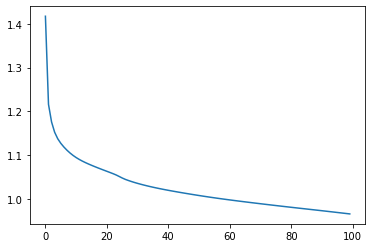

In [67]:
def mse_forward(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_backward(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

net = model(mse_forward, mse_backward)
net.add_layer(FullyConnectedLayer(10,20))
net.add_layer(ActivationLayer(tanh, tanh_prime))
net.add_layer(FullyConnectedLayer(20,10))
net.add_layer(ActivationLayer(tanh, tanh_prime))
net.add_layer(FullyConnectedLayer(10,5))
net.add_layer(ActivationLayer(tanh, tanh_prime))
net.add_layer(FullyConnectedLayer(5,1))

num_epochs = 100

log = net.fit(features_descriptors, labels, epochs=num_epochs, learning_rate=0.001)

plt.plot(list(range(num_epochs)), log, label='training loss')
plt.show()

Training it for 100 epochs on the continuous rdkit features we generated above, we can see that the implementation was successful and our model minimises the loss function and fits the data.

# Progressing to a Graph-Convolutional Network

Istead of operating on numeric feature vectors, as the feed-forward neural net above, graph-convolutional networks operate directly on graphs. I will focus on a widely-used architecture called Graph Attention Networks (GATs, https://arxiv.org/abs/1710.10903), although it should be said that there is a large number of different GNN architectures.

A GAT consists of layers that accept a set of feature vectors for each node and return a set of altered features, potentially adding or reducing dimensions.

$$ \left(\vec{h}_{1}, \vec{h}_{2}, \ldots, \vec{h}_{n}\right) \in \mathbf{R}^{n\times f} \to\left(\vec{h}_{1}^{\prime}, \vec{h}_{2}^{\prime}, \ldots, \vec{h}_{n}^{\prime}\right)\in \mathbf{R}^{n\times f^\prime}$$ 

The general architecture of a graph convolutional layer is given by 

$$
\vec{h}_{i}^{\prime}=\sigma\left(\sum_{j \in \mathcal{N}_{i}} \alpha_{i j} \vec{g}_{j}\right)
$$

where $\vec{g}_{i}=\mathbf{W} \vec{h}_{i}$ and $\sigma$ is a non-linear activation function. The GAT approach differs from other established methods by not specifying the coefficients $\alpha_{i j}$ beforehand, but calculating them through self-attention.

$$
\alpha_{i j}=\frac{\exp \left(e_{i j}\right)}{\sum_{k \in \mathcal{N}_{i}} \exp \left(e_{i k}\right)}=\frac{\exp (a(\vec{h}_{i}, \vec{h}_{j}))}{\sum_{k \in \mathcal{N}_{i}} \exp (a(\vec{h}_{i}, \vec{h}_{k}))}
$$

where $a(\cdot,\cdot)$ is a $2f^\prime\times 1$ single-layer feed-forward neural network trained on the concatenated feature vectors 

$$a(\vec{h}_{i}, \vec{h}_{j})=\sigma\left(\vec{\mathbf{a}}^{T}\left[\mathbf{W} \vec{h}_{i} \| \mathbf{W} \vec{h}_{j}\right]\right)$$

The attention mechanism allows the network to implicitly learn which substructures are more important for specific tasks and weigh them appropriately. The relative complexity of this model allows it to achieve state-of-the-art performance, but makes the implementation from scratch all the more difficult, as trying to implement the backpropagation with respect to the weight vector $\vec{\mathbf{a}}$ shows 

$$\frac{\partial E}{\partial \vec{\mathbf{a}}}=\frac{\partial E}{\partial \vec{h}_{i}}\frac{\partial  \vec{h}_{i}}{\partial \vec{\mathbf{a}}}=\frac{\partial E}{\partial \vec{h}_{i}}\sum_{j \in \mathcal{N}_{i}} \frac{\partial \alpha_{i j}}{\partial \vec{\mathbf{a}}} \vec{g}_{j}$$

$$
\frac{\partial \alpha_{i j}}{\partial \vec{\mathbf{a}}}=\frac{\exp \left(e_{i j}\right)}{\sum_{k \in \mathcal{N}_{i}} \exp \left(e_{i k}\right)}\left(\frac{\partial e_{i j}}{\partial \vec{\mathbf{a}}}-\frac{\sum_k\frac{\partial e_{i k}}{\partial \vec{\mathbf{a}}}\exp(e_{ik})}{\sum_{k \in \mathcal{N}_{i}} \exp \left(e_{i k}\right)}\right)
$$

$$
\frac{\partial e_{i j}}{\partial \vec{\mathbf{a}}}=\sigma^\prime\left(\vec{\mathbf{a}}^{T}\left[\mathbf{W} \vec{h}_{i} \| \mathbf{W} \vec{h}_{j}\right]\right)\odot \left[\mathbf{W} \vec{h}_{i} \| \mathbf{W} \vec{h}_{j}\right]
$$

While implementing a forward pass was relatively straight-forward, calculating and implementing the convoluted derivatives needed for the backward passes proved too complex and time-consuming for the limited duration of this project.

I definitely feel that I have gained a much better understanding of the backpropagation algorithm, but at the same time would probably use an existing machine learning framework (PyTorch, TensorFLow, ...) with built-in automated backwards passes, if I were to continue the implementation.

In [76]:
class GraphAttentionLayer(Layer):

    # input is list of node features

    # where input and output dims are the number of node features
    def __init__(self, A, input_dims, output_dims):
        """
        Initialising the GAT layer, where A is the graph adjacency matrix and the weights
        are initialised according to the Xavier method.
        """
        super(GraphAttentionLayer, self).__init__()
        self.A = A
        self.g = None
        self.weights = np.random.randn(input_dims, output_dims) * np.sqrt(6 / (input_dims + output_dims))
        self.attention_weights = np.random.randn(2 * output_dims, 1) * np.sqrt(6 / (2 * output_dims + 1))

    def _neighbours(self, node):
        """
        Returning a list of the neighbours of a specific node.
        """
        return np.nonzero(self.A[node, :])[0]

    def _calc_attention(self, node):
        """
        calculating the normalised attention coefficients
        """
        # calculating the unnormalised attention coefficients
        attention_coefs = np.zeros(self.input.shape[0])
        for n in self._neighbours(node):
            attention_features = np.hstack((self.g[node, :], self.g[n, :]))
            a = lrelu(np.dot(self.attention_weights.T, attention_features))
            attention_coefs[n] = a

        # normalising attention coefficients
        attention_coefs = np.where(attention_coefs != 0, np.exp(attention_coefs), 0)
        normalised_coefs = attention_coefs / np.sum(attention_coefs)

        return np.array(normalised_coefs)

    def forward_propagation(self, input):
        """
        Performing a forward pass through the network and calculating the 
        updated feature vectors
        """

        self.input = input
        self.g = self.input @ self.weights

        res = []

        for node in range(self.input.shape[0]):
            # get coefficients
            coefs = self._calc_attention(node)
            neighs = self._neighbours(node)
            summed = np.zeros(self.g.shape[1])
            for n in neighs:
                summed += coefs[n]*self.g[n, :]
            res.append(summed)

        return np.vstack(res)

    def backward_propagation(self, output_error, learning_rate):
        """
        Performing a backward pass through the network and updating its parameters,
        currently only implemented for the weights of the feed-forward network
        used to calculate the attention coefficients.
        """

        def e(i, j):
            return lrelu(np.dot(self.attention_weights.T, np.hstack((self.g[i, :], self.g[j, :]))))

        def de_da(i, j):
            inner = np.hstack((self.g[i, :], self.g[j, :]))
            outer = lrelu_prime(np.dot(self.attention_weights.T, inner))
            return inner * outer

        def dalpha_da(i, j):
            summed = 0
            summed_dif = 0
            for k in self._neighbours(i):
                summed += np.exp(e(i, k))
                summed_dif += de_da(i, k) * np.exp(e(i, k))

            return np.exp(e(i, j)) / summed * (de_da(i, j) - summed_dif / summed)

        nodes, dims = self.g.shape
        attention_error = np.zeros((nodes, 2*dims))

        for node in range(nodes):
            for n in self._neighbours(node):
                attention_error[node,:] += dalpha_da(node, n)

        attention_error = np.mean(attention_error, axis=0)

        self.attention_weights -= learning_rate*attention_error.reshape(-1,1)